# Simple CNN Model

In [206]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [207]:
from fastai.basics import *
import jkbc.utils.preprocessing as prep
import jkbc.utils.feather_files as ff
import jkbc.utils.files as f

In [208]:
FIXED_LABEL_LEN = 50
BS = 64
PAD_VAL = 4
D_IN = 300
C = 5

DEVICE_GPU = torch.device("cuda:0")
DEVICE_CPU = torch.device('cpu')
DEVICE = DEVICE_GPU

SPLIT = 0.8

In [209]:
path_base = Path("../data/")
path_hdf5 = path_base/"small_umi16to9.hdf5"
path_feather = path_base/"feather_files/"

In [210]:
# Create the feather files
# ff.make_new_with_range(path_hdf5, path_feather, range_ = range(0, 10), padding_val = PAD_VAL, label_len = FIXED_LABEL_LEN)

In [211]:
# Load the feather files
data_from_feather = f.read_data_from_feather_file(path_feather)

In [212]:
# Create databunch
ds_train, ds_valid = prep.convert_to_datasets(data_from_feather, split = SPLIT)
data = DataBunch.create(ds_train, ds_valid, bs=BS, device=DEVICE)

In [191]:
ctc_loss = nn.CTCLoss()
y_pred_lengths, y_lengths = prep.get_y_lengths(D_IN, FIXED_LABEL_LEN, BS)
def ctc_loss_custom(y_pred_b: torch.Tensor, y_b: torch.Tensor) -> float:
    if y_pred_lengths.shape[0] != y_pred_b.shape[0]:
        new_len = y_pred_b.shape[0]
        y_pred_lengths_ = y_pred_lengths[:new_len]
        y_lengths_ = y_lengths[:new_len]
    else:
        y_pred_lengths_ = y_pred_lengths
        y_lengths_ = y_lengths
    
    y_pred_b_ = y_pred_b.reshape((y_pred_b.shape[1], y_pred_b.shape[0], C))
    
    return ctc_loss(y_pred_b_, y_b, y_pred_lengths_, y_lengths_)    

In [216]:
data.one_batch()[0].shape

torch.Size([64, 300, 1])

In [197]:
model = nn.Sequential(
    nn.Reshape...
    nn.Conv1d(1, 5, 3, stride=2),
    nn.Flatten()
)

In [198]:
learner = Learner(data, model, loss_func=ctc_loss_custom, wd=0.1)

In [199]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Given groups=1, weight of size 5 1 3, expected input[64, 300, 1] to have 1 channels, but got 300 channels instead

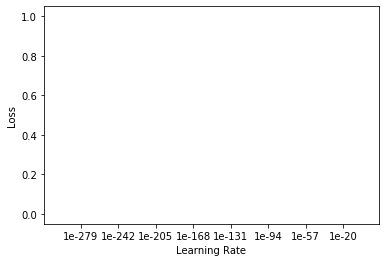

In [183]:
learner.recorder.plot()

In [194]:
# GPU
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,-1.229802,-0.333892,00:03
1,-0.040928,0.117442,00:03
2,0.662706,0.697852,00:03
3,0.736203,0.705349,00:03
4,0.751842,0.697581,00:03
5,0.749011,0.745628,00:03
6,0.750384,0.739541,00:03
7,0.753639,0.696406,00:03
8,0.749899,0.702070,00:03
9,0.755793,0.707330,00:03
